https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html was used as a reference for this notebook.

In [24]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tqdm import tqdm
from torcheval.metrics import FrechetInceptionDistance

# random seed for reproducibility
seed = 999
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Number of GPUs available
ngpu = 1

## Data Preparation

In [25]:
# Root directory for dataset
dataset_name = "celeba"
dataroot = "data/" + dataset_name

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# all training images will be resized to this size
image_size = 64

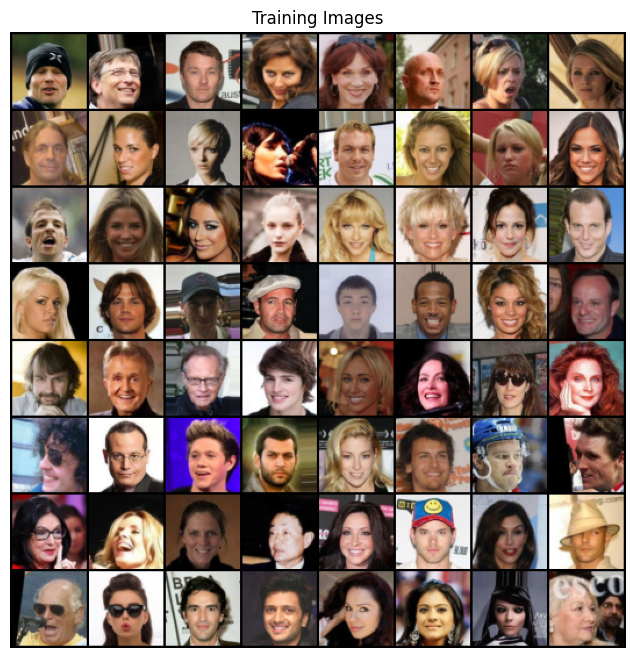

In [26]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.ImageFolder(root=dataroot, transform=transform)

# load CIFAR10 dataset
# trainset = dset.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('cifar10_training_images.png')
plt.show()

## Deep Convolutional GANs (DCGAN) Model Architecture
https://arxiv.org/pdf/1511.06434.pdf

In [27]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [28]:
# nr of channels in the training images
num_channels = 3

# Size of z latent vector
num_z = 100

# Size of feature maps in generator
num_gen_fearute_maps = 64

# Size of feature maps in discriminator
num_dics_fearute_maps = 64

## Definition of Generator

In [29]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( num_z, num_gen_fearute_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps * 8),
            nn.ReLU(True),
            # state size. ``(num_gen_fearute_maps*8) x 4 x 4``
            nn.ConvTranspose2d(num_gen_fearute_maps * 8, num_gen_fearute_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps * 4),
            nn.ReLU(True),
            # state size. ``(num_gen_fearute_maps*4) x 8 x 8``
            nn.ConvTranspose2d( num_gen_fearute_maps * 4, num_gen_fearute_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps * 2),
            nn.ReLU(True),
            # state size. ``(num_gen_fearute_maps*2) x 16 x 16``
            nn.ConvTranspose2d( num_gen_fearute_maps * 2, num_gen_fearute_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps),
            nn.ReLU(True),
            # state size. ``(num_gen_fearute_maps) x 32 x 32``
            nn.ConvTranspose2d( num_gen_fearute_maps, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(num_channels) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [30]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# randomly initialize all weights
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Definition of Discriminator

In [31]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(num_channels) x 64 x 64``
            nn.Conv2d(num_channels, num_dics_fearute_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_dics_fearute_maps) x 32 x 32``
            nn.Conv2d(num_dics_fearute_maps, num_dics_fearute_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_dics_fearute_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_dics_fearute_maps*2) x 16 x 16``
            nn.Conv2d(num_dics_fearute_maps * 2, num_dics_fearute_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_dics_fearute_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_dics_fearute_maps*4) x 8 x 8``
            nn.Conv2d(num_dics_fearute_maps * 4, num_dics_fearute_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_dics_fearute_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_dics_fearute_maps*8) x 4 x 4``
            nn.Conv2d(num_dics_fearute_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# randomly initialize all weights
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Training of DCGAN

Here we use the same hyperparameters as in the original paper: https://arxiv.org/pdf/1511.06434

In [33]:
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

In [34]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# batch of latent vectors to visualize the progression of the generator
fixed_noise = torch.randn(64, num_z, 1, 1, device=device)

# labels fot real and fake images
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [35]:
# Number of training epochs
num_epochs = 30

In [36]:
# logging of the training process
img_list = []
G_losses = []
D_losses = []
fid_score = {}
iters = 0
epochs = 0

In [ ]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, num_z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    epochs += 1

    # every 10 epochs calculate FIDand save the model
    if iters % 1000 == 0:
        # calculate FID
        fid = FrechetInceptionDistance()

        # generate 10000 images
        fake_images = []
        for i in tqdm(range(10000 // batch_size)):
            noise = torch.randn(1, num_z, 1, 1, device=device)
            fake_images.append(netG(noise).detach().cpu())
        fake_images = torch.cat(fake_images, dim=0)

        # real images
        real_images = next(iter(dataloader))[0][:10000].to(device)

        # When default inception-v3 model is used, images are expected to be in the [0, 1] interval
        real_images = (real_images + 1) / 2
        fake_images = (fake_images + 1) / 2

        fid.update(real_images, True)
        fid.update(fake_images, False)

        fid_score[iters] = fid.compute().item()

        # save model
        torch.save(netG.state_dict(), f'./models/dcgan/{dataset_name}/netG_{iters}.pth')
        torch.save(netD.state_dict(), f'./models/dcgan/{dataset_name}/netD_{iters}.pth')

        state = {
            'epochs': epochs,
            'iters': iters,
            'G_losses': G_losses,
            'D_losses': D_losses,
            'img_list': img_list,
            'fid_score': fid_score
        }

        torch.save(state, f'./models/dcgan/{dataset_name}state_{iters}.pth')

## Loading a trained model

In [37]:
# load the pretrained model
netG.load_state_dict(torch.load('models/dcgan/celeba/netG_31739.pth'))
netD.load_state_dict(torch.load('models/dcgan/celeba/netD_31739.pth'))

# load state
state = torch.load('models/dcgan/celeba/state_31739.pth')
epochs = state['epochs']
iters = state['iters']
G_losses = state['G_losses']
D_losses = state['D_losses']
img_list = state['img_list']
fid_score = state['fid_score']

## Generate random new images

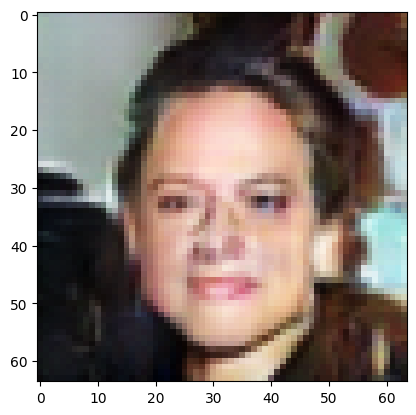

In [46]:
fixed_noise2 = torch.randn(1, num_z, 1, 1, device=device)
# Generate fake image batch with G
with torch.no_grad():
    fake = netG(fixed_noise2).detach().cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

## Perform Vector Arithmetic on Generated Images
first generate new images in the upper code cell, then store sutable images in the lower code cell to temporally store the images for vector arithmetic.

In [ ]:
fake0 = fake

In [ ]:
fake1 = fake

In [ ]:
fake2 = fake

In [ ]:
img = vutils.make_grid(fake0, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

In [ ]:
img = vutils.make_grid(fake1, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

In [ ]:
img = vutils.make_grid(fake2, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

In [ ]:
new_person = fake0 - fake1 + fake2

In [ ]:
img = vutils.make_grid(new_person, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

## Plot the Training Losses of the Generator and Discriminator

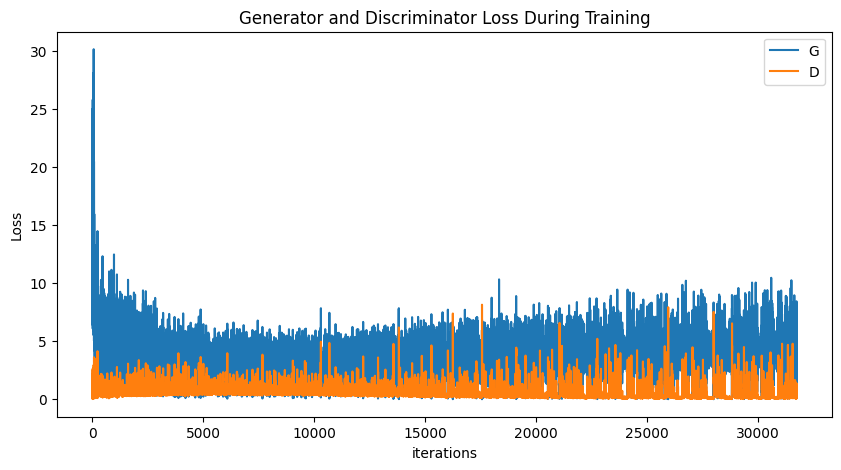

In [47]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('dcgan_loss.png')
plt.show()

## Analyze the generated images

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

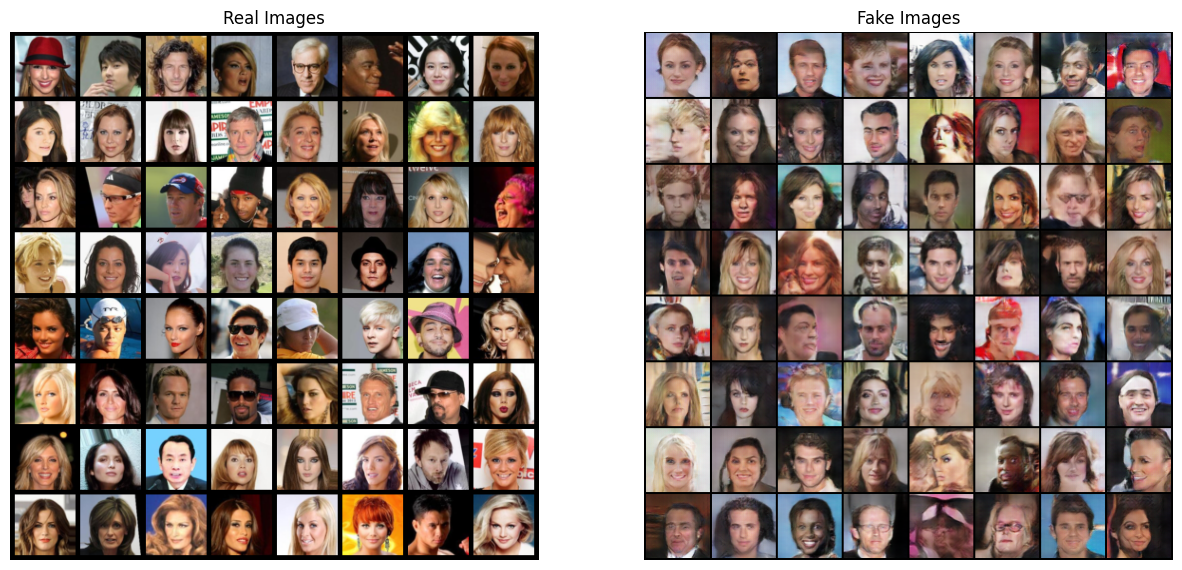

In [48]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()